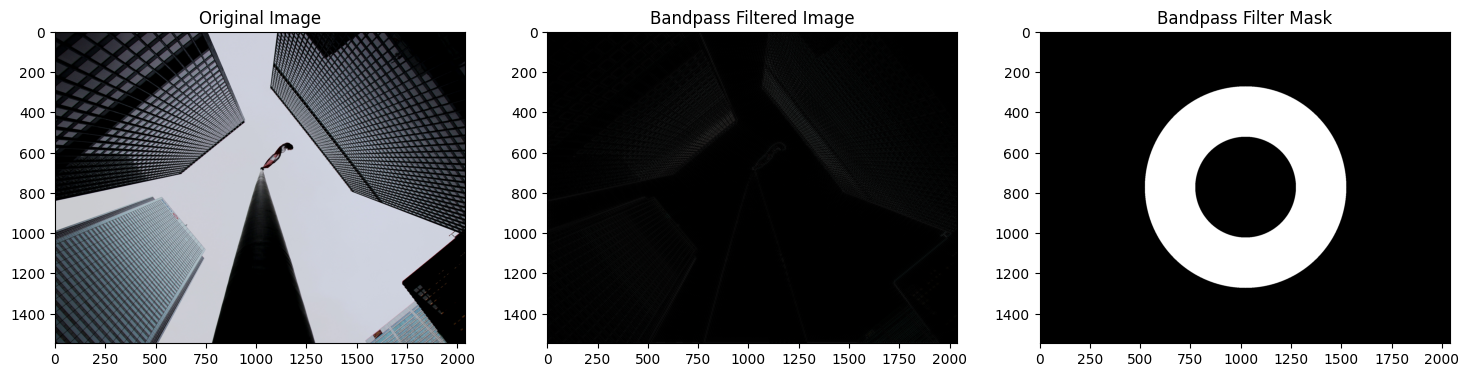

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from matplotlib.image import imread

def create_bandpass_filter(rows, cols, inner_radius, outer_radius):
    """
    创建一个环形带通滤波器。
    """
    center_row, center_col = rows // 2, cols // 2
    Y, X = np.ogrid[:rows, :cols]
    distance_from_center = np.sqrt((X - center_col)**2 + (Y - center_row)**2)
    bandpass_filter = np.logical_and(distance_from_center >= inner_radius, distance_from_center <= outer_radius)
    return bandpass_filter

def apply_bandpass_filter(image, inner_radius, outer_radius):
    """
    对图像的每个通道应用环形带通滤波器。
    """
    # 仅使用第一个通道来创建和显示滤波器掩码
    channel = image[:, :, 0] if image.ndim == 3 else image
    filter_mask = create_bandpass_filter(*channel.shape, inner_radius, outer_radius)
    
    filtered_channels = []
    for c in range(image.shape[2]):
        channel = image[:, :, c]
        
        fft_result = fft2(channel)
        fft_shifted = fftshift(fft_result)
        
        fft_filtered = fft_shifted * filter_mask
        channel_filtered = ifft2(ifftshift(fft_filtered)).real
        filtered_channels.append(channel_filtered)
        
    return np.stack(filtered_channels, axis=2), filter_mask

# 加载并准备图像
image_path = '/home/yinqiang/fourier-feature-networks/0188.png' # 请确保替换为正确的路径
image = imread(image_path)  # 直接读取图像，不做归一化处理

if image.ndim == 2 or image.shape[2] == 1:  # 如果是灰度图像
    image = np.stack([image]*3, axis=-1)  # 转换为三通道图像

# 定义带通滤波器参数
inner_radius = 250
outer_radius = 500

# 应用带通滤波器
filtered_image, filter_mask = apply_bandpass_filter(image / 255.0, inner_radius, outer_radius)  # 归一化处理

# 展示时将滤波后的图像值乘以255
filtered_image = np.clip(filtered_image * 255, 0, 255)  # 修正后的像素值，并确保值在合法范围内

# 显示结果
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(filtered_image.astype(np.uint8))
plt.title('Bandpass Filtered Image')
plt.subplot(1, 3, 3)
plt.imshow(filter_mask, cmap='gray')
plt.title('Bandpass Filter Mask')
plt.show()



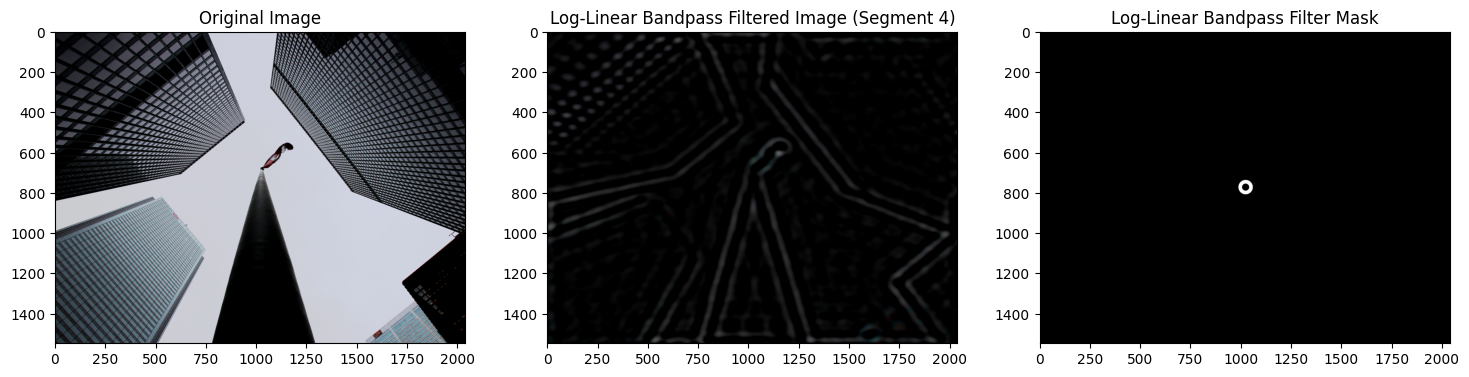

[[[0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 1.2007207e-04]
  [1.5660244e-05 2.9860312e-05 5.1280865e-03]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 3.2248357e-03]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 1.3695778e-03]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]]

 ...

 [[0.0000000e+00 0.0000000e+00 7.5228169e-04]
  [0.0000000e+00 5.3514412e-04 6.0549621e-03]
  [2.2223983e-03 5.2612261e-03 1.1169549e-02]
  ..

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from matplotlib.image import imread

def apply_log_linear_bandpass_filter(image, segment_index, max_len):
    """
    对图像应用对数线性分段的带通滤波器。
    """
    rows, cols = image.shape[:2]
    center_row, center_col = rows // 2, cols // 2
    Y, X = np.ogrid[:rows, :cols]
    distance_from_center = np.sqrt((X - center_col)**2 + (Y - center_row)**2)
    
    max_distance = np.sqrt(center_row**2 + center_col**2)

    
    # 计算对数线性的分段边界
    log_distances =np.linspace(0, np.log(max_distance), max_len + 1)
    inner_radius = np.exp(log_distances[segment_index])
    outer_radius = np.exp(log_distances[segment_index + 1])
    
    bandpass_filter = np.logical_and(distance_from_center >= inner_radius, distance_from_center < outer_radius)
    
    filtered_channels = []
    for c in range(image.shape[2]):
        channel = image[:, :, c]
        
        fft_result = fft2(channel)
        fft_shifted = fftshift(fft_result)
        
        fft_filtered = fft_shifted * bandpass_filter
        channel_filtered = ifft2(ifftshift(fft_filtered)).real
        filtered_channels.append(channel_filtered)
        
    return np.stack(filtered_channels, axis=2), bandpass_filter

# 加载并准备图像
image_path = '/home/yinqiang/fourier-feature-networks/0188.png'   # 请确保替换为正确的路径
image = imread(image_path)  # 归一化图像

if image.ndim == 2 or image.shape[2] == 1:  # 如果是灰度图像
    image = np.stack([image]*3, axis=-1)  # 转换为三通道图像

# 定义分段和选定的段
max_len = 10# 总段数
segment_index = 4  # 选定的段，从0开始计数

# 应用对数线性分段的带通滤波器
filtered_image, bandpass_filter = apply_log_linear_bandpass_filter(image/255.0, segment_index, max_len)
filtered_image = np.clip(filtered_image * 255, 0, 255) 
# 显示结果
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(filtered_image)
plt.title(f'Log-Linear Bandpass Filtered Image (Segment {segment_index})')
plt.subplot(1, 3, 3)
plt.imshow(bandpass_filter, cmap='gray')
plt.title('Log-Linear Bandpass Filter Mask')
plt.show()
print(filtered_image)
